## Logistic regressions

Try with logistic regressions **using the OverFeat features** in a "Logistic regressions.ipynb" notebook.

**Q:** Create a logistic regression classifier and tune the regularication strength.

In [1]:
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
import random

%matplotlib inline

# Load data
with np.load('cifar4-train.npz', allow_pickle=False) as npz_file:
    cifar4 = dict(npz_file.items())

#let's take a look at the keys
print('Data loaded')
print('It is a dictionary with keys:', list(cifar4.keys()))

Data loaded
It is a dictionary with keys: ['pixels', 'overfeat', 'labels', 'names', 'allow_pickle']


In [2]:
# Create X/y arrays
X = cifar4['overfeat']
y = cifar4['labels']
pixels = cifar4['pixels']

print('X:', X.shape, X.dtype)
print('y:', y.shape, y.dtype)

X: (5000, 4096) float32
y: (5000,) int64


In [3]:
# Split data into train/test sets
X_tr, X_te, y_tr, y_te, pixels_tr, pixels_te = train_test_split(
    X, y, pixels, train_size=4000, test_size=1000, stratify = y, random_state=0)

In [4]:
#let's make sure of the uniform distribution of the data in the train set
pd.value_counts(y_tr, normalize = 'True')

3    0.25
1    0.25
2    0.25
0    0.25
dtype: float64

**Q:** Fit a logistic regression with an **L2** regularization term and tune the regularization strength using **grid search with cross-validation**. Use a stratified 5-fold strategy.

**Note:** You can use the **SGDClassifier** estimator which should be faster than the **LogisticRegression** one. You can set the logistic loss with its **loss** parameter. Also, set the maximum number of iterations and the stopping criteria with the **max_iter** and the **tol** parameters.

When doing grid search, **try with and without PCA** and tune the number of components in addition to the regularization strength. To achieve this, encapsulate your logistic regression into a pipeline with an optional PCA preprocessing step and create two grids of parameters - one with and one one without PCA. Collect the results in a DataFrame.

In [5]:
# Create the pipeline and fit it to training data
pca = PCA() #retain 90% of the variance explained
#logreg = LogisticRegression(multi_class='ovr', random_state=0)
logreg = SGDClassifier(
    # Set logistic loss
    loss = 'log',
    # Set max number of iterations and stopping criteria
    max_iter = 1000, tol = 1e-3, random_state = 0
)

# the pipeline considering PCA
pipe_pca = Pipeline([
    ('pca', pca), # The number of components in PCA are adopted from the "Data exploration" section
    ('logreg', logreg)
])

In [6]:
# let's define the values of parameters for grid search
alpha_list = np.logspace(-4, 4, 10)
n_pca_comp = [None, 176]

# Grid search with cross-validation
grid = {
    'logreg__alpha': alpha_list,
    'pca__n_components': n_pca_comp
}
grid_pca_cv = GridSearchCV(pipe_pca, grid, cv=5, n_jobs = 3)

# Fit it to train data
grid_pca_cv.fit(X_tr, y_tr)

# Collect results in a DataFrame
logreg_score = pd.DataFrame.from_items([
    ('n components', grid_pca_cv.cv_results_['param_pca__n_components']),
    ('alpha', grid_pca_cv.cv_results_['param_logreg__alpha']),
    ('mean accuracy', grid_pca_cv.cv_results_['mean_test_score']),
    ('standard deviation', grid_pca_cv.cv_results_['std_test_score'])
])

logreg_score

n components        alpha  mean accuracy  standard deviation
0          None       0.0001        0.83300            0.015012
1           176       0.0001        0.81775            0.011869
2          None  0.000774264        0.83600            0.013309
3           176  0.000774264        0.82825            0.014845
4          None   0.00599484        0.83575            0.011500
5           176   0.00599484        0.82575            0.009441
6          None    0.0464159        0.82950            0.013477
7           176    0.0464159        0.82275            0.011495
8          None     0.359381        0.83150            0.013309
9           176     0.359381        0.82300            0.013053
10         None      2.78256        0.81250            0.012674
11          176      2.78256        0.81075            0.011308
12         None      21.5443        0.75775            0.009165
13          176      21.5443        0.75750            0.008768
14         None       166.81        0.62000            0.007786
15          176       166.81        0.61950            0.007228
16         None      1291.55        0.28650            0.004835
17          176      1291.55        0.28625            0.005000
18         None        10000        0.25000            0.000000
19          176        10000        0.25000            0.000000

**Q:** Find the combination of parameters that maximizes the mean accuracy and print it. Also, evaluate the test accuracy of your tuned estimator.

In [7]:
# let's find the row id where the value in 'validation accuracy' column
row_id = logreg_score['mean accuracy'].idxmax()

print('Top accuracy across folds: ', logreg_score['mean accuracy'].at[row_id], ' (std: ', 
      logreg_score['standard deviation'].at[row_id], ') with ', logreg_score['n components'].at[row_id],
      ' components and alpha: ', logreg_score['alpha'].at[row_id])

Top accuracy across folds:  0.836  (std:  0.013308831654206148 ) with  None  components and alpha:  0.000774263682681127


In [8]:
# Insert optimum number of components and alpha parameters
pipe_pca_tuned = Pipeline([
    ('pca', PCA(n_components = None)),
    ('logreg', SGDClassifier(
    alpha = 0.000774263682681,
    loss = 'log',
    max_iter = 1000, tol = 1e-3, random_state = 0
))
])

# Fit the tuned pipelines in the entire train set
pipe_pca_tuned.fit(X_tr, y_tr)

# Save accuracy on test set
logreg_accuracy = pipe_pca_tuned.score(X_te, y_te)

#let's print the accuracies of the test set
print('Logistic regression accuracy (test set): ', logreg_accuracy)

Logistic regression accuracy (test set):  0.838


**Q:** **Pick ten images from the test set** and compute the probability of each class using the *predict_proba()* funtion of your estimator. Plot the results.

In [9]:
#choose ten random images from the test set
rand_id = []

for random_counter in np.arange(10):
    rand_id.append(random.randint(0,1000))

Image  1


Image  2


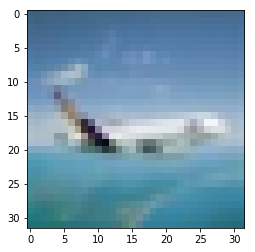

Image  3


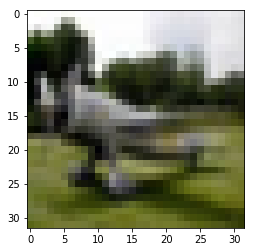

Image  4


Image  5


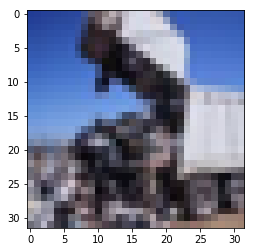

Image  6


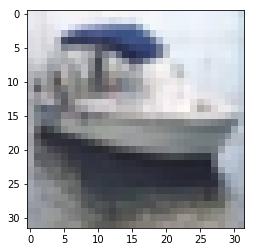

Image  7


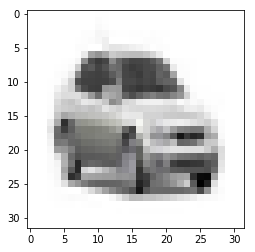

Image  8


Image  9


Image  10


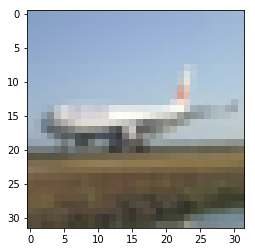

In [10]:
# Function to plot the i-th image from some X/y arrays
def show_image(item, X, label):
    # Get image pixels from the input matrix X
    flat_img = X[item] # has shape (3072,)
    
   # Reshape the "flat vector" into a 32x32x3 array 
    img = flat_img.reshape(32, 32, 3)
    
    # Print label using the output vector y
    print('Image ', label)
    
    # Plot image with pyplot
    plt.imshow(img, cmap=plt.cm.gray_r)
    plt.show()

counter = 0
for image_id in rand_id:
    counter += 1
    show_image(image_id, pixels_te, counter)

In [11]:
logreg_predict = pd.DataFrame(columns=['truck', 'car', 'airplane', 'ship'])

counter = 0
for image_id in rand_id:
    counter += 1
    temp_df = pd.DataFrame(data = np.round(pipe_pca_tuned.predict_proba(X_te[image_id].reshape(1, -1)), 4), index = ['Image ' + str(counter)], columns=['truck', 'car', 'airplane', 'ship'])
    logreg_predict = pd.concat([logreg_predict, temp_df])
    
logreg_predict

C:\Users\Arash\Anaconda3\envs\exts-aml2\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


truck     car  airplane    ship
Image 1   0.0000  0.0000    0.0000  1.0000
Image 2   0.0000  0.0000    0.5333  0.4667
Image 3   0.0000  0.0000    1.0000  0.0000
Image 4   0.0000  0.0000    1.0000  0.0000
Image 5   0.5000  0.0000    0.5000  0.0000
Image 6   0.0000  0.0000    0.0000  1.0000
Image 7   0.0000  1.0000    0.0000  0.0000
Image 8   0.1672  0.8328    0.0000  0.0000
Image 9   1.0000  0.0000    0.0000  0.0000
Image 10  0.0000  0.0000    0.5000  0.5000

Finally, try to vary the regularization strength of your estimator. What is the effect on the probabilities? **Write your observations** in a markdown cell.

In [12]:
# new regularization strength ... try 1
pipe_pca_tuned_tr1 = Pipeline([
    ('pca', PCA(n_components = None)),
    ('logreg', SGDClassifier(
    alpha = 0.000774263682681 * 2,
    loss = 'log',
    max_iter = 1000, tol = 1e-3, random_state = 0
))
])

#fit the new pipeline
pipe_pca_tuned_tr1.fit(X_tr, y_tr)

# find the new probabilities
logreg_predict_tr1 = pd.DataFrame(columns=['truck', 'car', 'airplane', 'ship'])

counter = 0
for image_id in rand_id:
    counter += 1
    temp_df = pd.DataFrame(data = np.round(pipe_pca_tuned_tr1.predict_proba(X_te[image_id].reshape(1, -1)), 4), index = ['Image ' + str(counter)], columns=['truck', 'car', 'airplane', 'ship'])
    logreg_predict_tr1 = pd.concat([logreg_predict_tr1, temp_df])
    
logreg_predict_tr1

C:\Users\Arash\Anaconda3\envs\exts-aml2\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


truck     car  airplane  ship
Image 1   0.0000  0.0000       0.0   1.0
Image 2   0.0000  0.0000       1.0   0.0
Image 3   0.0000  0.0000       1.0   0.0
Image 4   0.0000  0.0000       1.0   0.0
Image 5   0.5000  0.0000       0.5   0.0
Image 6   0.0000  0.0000       0.0   1.0
Image 7   0.0000  1.0000       0.0   0.0
Image 8   0.2623  0.7377       0.0   0.0
Image 9   1.0000  0.0000       0.0   0.0
Image 10  0.0000  0.0000       0.5   0.5

In [13]:
# new regularization strength ... try 2
pipe_pca_tuned_tr2 = Pipeline([
    ('pca', PCA(n_components = None)),
    ('logreg', SGDClassifier(
    alpha = 0.000774263682681 * 5,
    loss = 'log',
    max_iter = 1000, tol = 1e-3, random_state = 0
))
])

#fit the new pipeline
pipe_pca_tuned_tr2.fit(X_tr, y_tr)

# find the new probabilities
logreg_predict_tr2 = pd.DataFrame(columns=['truck', 'car', 'airplane', 'ship'])

counter = 0
for image_id in rand_id:
    counter += 1
    temp_df = pd.DataFrame(data = np.round(pipe_pca_tuned_tr2.predict_proba(X_te[image_id].reshape(1, -1)), 4), index = ['Image ' + str(counter)], columns=['truck', 'car', 'airplane', 'ship'])
    logreg_predict_tr2 = pd.concat([logreg_predict_tr2, temp_df])
    
logreg_predict_tr2

C:\Users\Arash\Anaconda3\envs\exts-aml2\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


truck     car  airplane  ship
Image 1   0.0000  0.0000       0.0   1.0
Image 2   0.0000  0.0000       1.0   0.0
Image 3   0.0000  0.0000       1.0   0.0
Image 4   0.0000  0.0000       1.0   0.0
Image 5   0.5000  0.0000       0.5   0.0
Image 6   0.0000  0.0000       0.0   1.0
Image 7   0.0000  1.0000       0.0   0.0
Image 8   0.0003  0.9997       0.0   0.0
Image 9   1.0000  0.0000       0.0   0.0
Image 10  0.0000  0.0000       0.5   0.5

In [14]:
# new regularization strength ... try 3
pipe_pca_tuned_tr3 = Pipeline([
    ('pca', PCA(n_components = None)),
    ('logreg', SGDClassifier(
    alpha = 0.000774263682681 * 10,
    loss = 'log',
    max_iter = 1000, tol = 1e-3, random_state = 0
))
])

#fit the new pipeline
pipe_pca_tuned_tr3.fit(X_tr, y_tr)

# find the new probabilities
logreg_predict_tr3 = pd.DataFrame(columns=['truck', 'car', 'airplane', 'ship'])

counter = 0
for image_id in rand_id:
    counter += 1
    temp_df = pd.DataFrame(data = np.round(pipe_pca_tuned_tr3.predict_proba(X_te[image_id].reshape(1, -1)), 4), index = ['Image ' + str(counter)], columns=['truck', 'car', 'airplane', 'ship'])
    logreg_predict_tr3 = pd.concat([logreg_predict_tr3, temp_df])
    
logreg_predict_tr3

truck  car  airplane    ship
Image 1     0.0  0.0    0.0000  1.0000
Image 2     0.0  0.0    0.8647  0.1353
Image 3     0.0  0.0    1.0000  0.0000
Image 4     0.0  0.0    1.0000  0.0000
Image 5     0.5  0.0    0.5000  0.0000
Image 6     0.0  0.0    0.0000  1.0000
Image 7     0.0  1.0    0.0000  0.0000
Image 8     0.0  1.0    0.0000  0.0000
Image 9     1.0  0.0    0.0000  0.0000
Image 10    0.0  0.0    0.5000  0.5000

In [15]:
# new regularization strength ... try 4
pipe_pca_tuned_tr4 = Pipeline([
    ('pca', PCA(n_components = None)),
    ('logreg', SGDClassifier(
    alpha = 0.000774263682681 * 50,
    loss = 'log',
    max_iter = 1000, tol = 1e-3, random_state = 0
))
])

#fit the new pipeline
pipe_pca_tuned_tr4.fit(X_tr, y_tr)

# find the new probabilities
logreg_predict_tr4 = pd.DataFrame(columns=['truck', 'car', 'airplane', 'ship'])

counter = 0
for image_id in rand_id:
    counter += 1
    temp_df = pd.DataFrame(data = np.round(pipe_pca_tuned_tr4.predict_proba(X_te[image_id].reshape(1, -1)), 4), index = ['Image ' + str(counter)], columns=['truck', 'car', 'airplane', 'ship'])
    logreg_predict_tr4 = pd.concat([logreg_predict_tr4, temp_df])
    
logreg_predict_tr4

truck     car  airplane    ship
Image 1   0.0000  0.0000    0.0000  1.0000
Image 2   0.0000  0.0000    0.6213  0.3787
Image 3   0.0000  0.0000    1.0000  0.0000
Image 4   0.0000  0.0000    0.9948  0.0052
Image 5   0.4821  0.0000    0.5179  0.0000
Image 6   0.0000  0.0004    0.0000  0.9996
Image 7   0.0000  1.0000    0.0000  0.0000
Image 8   0.0051  0.9949    0.0000  0.0000
Image 9   1.0000  0.0000    0.0000  0.0000
Image 10  0.0000  0.0000    0.4874  0.5126

In [16]:
# new regularization strength ... try 5
pipe_pca_tuned_tr5 = Pipeline([
    ('pca', PCA(n_components = None)),
    ('logreg', SGDClassifier(
    alpha = 0.000774263682681 * 100,
    loss = 'log',
    max_iter = 1000, tol = 1e-3, random_state = 0
))
])

#fit the new pipeline
pipe_pca_tuned_tr5.fit(X_tr, y_tr)

# find the new probabilities
logreg_predict_tr5 = pd.DataFrame(columns=['truck', 'car', 'airplane', 'ship'])

counter = 0
for image_id in rand_id:
    counter += 1
    temp_df = pd.DataFrame(data = np.round(pipe_pca_tuned_tr5.predict_proba(X_te[image_id].reshape(1, -1)), 4), index = ['Image ' + str(counter)], columns=['truck', 'car', 'airplane', 'ship'])
    logreg_predict_tr5 = pd.concat([logreg_predict_tr5, temp_df])
    
logreg_predict_tr5

truck     car  airplane    ship
Image 1   0.0000  0.0000    0.0014  0.9986
Image 2   0.0000  0.0000    0.4557  0.5443
Image 3   0.0000  0.0000    0.9996  0.0004
Image 4   0.0000  0.0003    0.8955  0.1042
Image 5   0.4384  0.0000    0.5616  0.0000
Image 6   0.0001  0.0078    0.0000  0.9921
Image 7   0.0002  0.9998    0.0000  0.0000
Image 8   0.0274  0.9726    0.0000  0.0000
Image 9   1.0000  0.0000    0.0000  0.0000
Image 10  0.0000  0.0000    0.4440  0.5560

In [17]:
# new regularization strength ... try 6
pipe_pca_tuned_tr6 = Pipeline([
    ('pca', PCA(n_components = None)),
    ('logreg', SGDClassifier(
    alpha = 0.000774263682681 * 500,
    loss = 'log',
    max_iter = 1000, tol = 1e-3, random_state = 0
))
])

#fit the new pipeline
pipe_pca_tuned_tr6.fit(X_tr, y_tr)

# find the new probabilities
logreg_predict_tr6 = pd.DataFrame(columns=['truck', 'car', 'airplane', 'ship'])

counter = 0
for image_id in rand_id:
    counter += 1
    temp_df = pd.DataFrame(data = np.round(pipe_pca_tuned_tr6.predict_proba(X_te[image_id].reshape(1, -1)), 4), index = ['Image ' + str(counter)], columns=['truck', 'car', 'airplane', 'ship'])
    logreg_predict_tr6 = pd.concat([logreg_predict_tr6, temp_df])
    
logreg_predict_tr6

truck     car  airplane    ship
Image 1   0.0002  0.0000    0.0860  0.9137
Image 2   0.0000  0.0000    0.4447  0.5553
Image 3   0.0167  0.0070    0.9079  0.0684
Image 4   0.0005  0.0458    0.5753  0.3784
Image 5   0.4331  0.0016    0.5428  0.0225
Image 6   0.0653  0.1005    0.0607  0.7735
Image 7   0.0553  0.9400    0.0001  0.0046
Image 8   0.1162  0.8519    0.0318  0.0001
Image 9   0.9774  0.0037    0.0040  0.0150
Image 10  0.0019  0.0000    0.4301  0.5680

In [18]:
# new regularization strength ... try 7
pipe_pca_tuned_tr7 = Pipeline([
    ('pca', PCA(n_components = None)),
    ('logreg', SGDClassifier(
    alpha = 0.000774263682681 * 1000,
    loss = 'log',
    max_iter = 1000, tol = 1e-3, random_state = 0
))
])

#fit the new pipeline
pipe_pca_tuned_tr7.fit(X_tr, y_tr)

# find the new probabilities
logreg_predict_tr7 = pd.DataFrame(columns=['truck', 'car', 'airplane', 'ship'])

counter = 0
for image_id in rand_id:
    counter += 1
    temp_df = pd.DataFrame(data = np.round(pipe_pca_tuned_tr7.predict_proba(X_te[image_id].reshape(1, -1)), 4), index = ['Image ' + str(counter)], columns=['truck', 'car', 'airplane', 'ship'])
    logreg_predict_tr7 = pd.concat([logreg_predict_tr7, temp_df])
    
logreg_predict_tr7

truck     car  airplane    ship
Image 1   0.0058  0.0001    0.1441  0.8499
Image 2   0.0000  0.0001    0.4165  0.5834
Image 3   0.0663  0.0359    0.7446  0.1532
Image 4   0.0041  0.1286    0.4642  0.4031
Image 5   0.4184  0.0152    0.4959  0.0704
Image 6   0.1156  0.1794    0.1191  0.5859
Image 7   0.1453  0.8200    0.0030  0.0317
Image 8   0.2105  0.6728    0.1151  0.0016
Image 9   0.8903  0.0217    0.0241  0.0638
Image 10  0.0201  0.0002    0.4082  0.5715

In [19]:
# new regularization strength ... try 8
pipe_pca_tuned_tr8 = Pipeline([
    ('pca', PCA(n_components = None)),
    ('logreg', SGDClassifier(
    alpha = 0.000774263682681 / 2,
    loss = 'log',
    max_iter = 1000, tol = 1e-3, random_state = 0
))
])

#fit the new pipeline
pipe_pca_tuned_tr8.fit(X_tr, y_tr)

# find the new probabilities
logreg_predict_tr8 = pd.DataFrame(columns=['truck', 'car', 'airplane', 'ship'])

counter = 0
for image_id in rand_id:
    counter += 1
    temp_df = pd.DataFrame(data = np.round(pipe_pca_tuned_tr8.predict_proba(X_te[image_id].reshape(1, -1)), 4), index = ['Image ' + str(counter)], columns=['truck', 'car', 'airplane', 'ship'])
    logreg_predict_tr8 = pd.concat([logreg_predict_tr8, temp_df])
    
logreg_predict_tr8

C:\Users\Arash\Anaconda3\envs\exts-aml2\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


truck     car  airplane  ship
Image 1   0.0000  0.0000       0.0   1.0
Image 2   0.0000  0.0000       1.0   0.0
Image 3   0.0000  0.0000       1.0   0.0
Image 4   0.0000  0.0000       1.0   0.0
Image 5   0.5000  0.0000       0.5   0.0
Image 6   0.0000  0.0000       0.0   1.0
Image 7   0.0000  1.0000       0.0   0.0
Image 8   0.4535  0.5465       0.0   0.0
Image 9   1.0000  0.0000       0.0   0.0
Image 10  0.0000  0.0000       0.5   0.5

In [20]:
# new regularization strength ... try 9
pipe_pca_tuned_tr9 = Pipeline([
    ('pca', PCA(n_components = None)),
    ('logreg', SGDClassifier(
    alpha = 0.000774263682681 / 5,
    loss = 'log',
    max_iter = 1000, tol = 1e-3, random_state = 0
))
])

#fit the new pipeline
pipe_pca_tuned_tr9.fit(X_tr, y_tr)

# find the new probabilities
logreg_predict_tr9 = pd.DataFrame(columns=['truck', 'car', 'airplane', 'ship'])

counter = 0
for image_id in rand_id:
    counter += 1
    temp_df = pd.DataFrame(data = np.round(pipe_pca_tuned_tr9.predict_proba(X_te[image_id].reshape(1, -1)), 4), index = ['Image ' + str(counter)], columns=['truck', 'car', 'airplane', 'ship'])
    logreg_predict_tr9 = pd.concat([logreg_predict_tr9, temp_df])
    
logreg_predict_tr9

C:\Users\Arash\Anaconda3\envs\exts-aml2\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


truck  car  airplane    ship
Image 1     0.0  0.0    0.0000  1.0000
Image 2     0.0  0.0    1.0000  0.0000
Image 3     0.0  0.0    1.0000  0.0000
Image 4     0.0  0.0    0.9631  0.0369
Image 5     0.5  0.0    0.5000  0.0000
Image 6     0.0  0.0    0.0000  1.0000
Image 7     0.0  1.0    0.0000  0.0000
Image 8     0.0  1.0    0.0000  0.0000
Image 9     1.0  0.0    0.0000  0.0000
Image 10    0.0  0.0    0.5000  0.5000

In [21]:
# new regularization strength ... try 10
pipe_pca_tuned_tr10 = Pipeline([
    ('pca', PCA(n_components = None)),
    ('logreg', SGDClassifier(
    alpha = 0.000774263682681 / 10,
    loss = 'log',
    max_iter = 1000, tol = 1e-3, random_state = 0
))
])

#fit the new pipeline
pipe_pca_tuned_tr10.fit(X_tr, y_tr)

# find the new probabilities
logreg_predict_tr10 = pd.DataFrame(columns=['truck', 'car', 'airplane', 'ship'])

counter = 0
for image_id in rand_id:
    counter += 1
    temp_df = pd.DataFrame(data = np.round(pipe_pca_tuned_tr10.predict_proba(X_te[image_id].reshape(1, -1)), 4), index = ['Image ' + str(counter)], columns=['truck', 'car', 'airplane', 'ship'])
    logreg_predict_tr10 = pd.concat([logreg_predict_tr10, temp_df])
    
logreg_predict_tr10

C:\Users\Arash\Anaconda3\envs\exts-aml2\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\Users\Arash\Anaconda3\envs\exts-aml2\lib\site-packages\sklearn\linear_model\base.py:347: RuntimeWarning: invalid value encountered in true_divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


truck  car  airplane  ship
Image 1     0.0  0.0       0.0   1.0
Image 2     0.0  0.0       1.0   0.0
Image 3     0.0  0.0       1.0   0.0
Image 4     NaN  NaN       NaN   NaN
Image 5     0.0  0.0       1.0   0.0
Image 6     0.0  0.0       0.0   1.0
Image 7     0.0  1.0       0.0   0.0
Image 8     0.5  0.5       0.0   0.0
Image 9     1.0  0.0       0.0   0.0
Image 10    0.0  0.0       0.5   0.5

In [22]:
# new regularization strength ... try 11
pipe_pca_tuned_tr11 = Pipeline([
    ('pca', PCA(n_components = None)),
    ('logreg', SGDClassifier(
    alpha = 0.000774263682681 / 50,
    loss = 'log',
    max_iter = 1000, tol = 1e-3, random_state = 0
))
])

#fit the new pipeline
pipe_pca_tuned_tr11.fit(X_tr, y_tr)

# find the new probabilities
logreg_predict_tr11 = pd.DataFrame(columns=['truck', 'car', 'airplane', 'ship'])

counter = 0
for image_id in rand_id:
    counter += 1
    temp_df = pd.DataFrame(data = np.round(pipe_pca_tuned_tr11.predict_proba(X_te[image_id].reshape(1, -1)), 4), index = ['Image ' + str(counter)], columns=['truck', 'car', 'airplane', 'ship'])
    logreg_predict_tr11 = pd.concat([logreg_predict_tr11, temp_df])
    
logreg_predict_tr11

C:\Users\Arash\Anaconda3\envs\exts-aml2\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\Users\Arash\Anaconda3\envs\exts-aml2\lib\site-packages\sklearn\linear_model\base.py:347: RuntimeWarning: invalid value encountered in true_divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


truck  car  airplane  ship
Image 1     0.0  0.0       0.0   1.0
Image 2     0.0  0.0       1.0   0.0
Image 3     0.0  0.0       1.0   0.0
Image 4     NaN  NaN       NaN   NaN
Image 5     0.0  0.0       1.0   0.0
Image 6     NaN  NaN       NaN   NaN
Image 7     0.0  1.0       0.0   0.0
Image 8     0.5  0.5       0.0   0.0
Image 9     1.0  0.0       0.0   0.0
Image 10    0.0  0.0       0.5   0.5

In [23]:
# new regularization strength ... try 12
pipe_pca_tuned_tr12 = Pipeline([
    ('pca', PCA(n_components = None)),
    ('logreg', SGDClassifier(
    alpha = 0.000774263682681 / 100,
    loss = 'log',
    max_iter = 1000, tol = 1e-3, random_state = 0
))
])

#fit the new pipeline
pipe_pca_tuned_tr12.fit(X_tr, y_tr)

# find the new probabilities
logreg_predict_tr12 = pd.DataFrame(columns=['truck', 'car', 'airplane', 'ship'])

counter = 0
for image_id in rand_id:
    counter += 1
    temp_df = pd.DataFrame(data = np.round(pipe_pca_tuned_tr12.predict_proba(X_te[image_id].reshape(1, -1)), 4), index = ['Image ' + str(counter)], columns=['truck', 'car', 'airplane', 'ship'])
    logreg_predict_tr12 = pd.concat([logreg_predict_tr12, temp_df])
    
logreg_predict_tr12

C:\Users\Arash\Anaconda3\envs\exts-aml2\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


truck  car  airplane  ship
Image 1     0.0  0.0       0.0   1.0
Image 2     0.0  0.0       0.5   0.5
Image 3     0.0  0.0       1.0   0.0
Image 4     0.0  0.0       0.0   1.0
Image 5     1.0  0.0       0.0   0.0
Image 6     0.0  0.0       0.0   1.0
Image 7     0.0  1.0       0.0   0.0
Image 8     0.5  0.5       0.0   0.0
Image 9     1.0  0.0       0.0   0.0
Image 10    0.0  0.0       0.5   0.5

In [24]:
# new regularization strength ... try 13
pipe_pca_tuned_tr13 = Pipeline([
    ('pca', PCA(n_components = None)),
    ('logreg', SGDClassifier(
    alpha = 0.000774263682681 / 500,
    loss = 'log',
    max_iter = 1000, tol = 1e-3, random_state = 0
))
])

#fit the new pipeline
pipe_pca_tuned_tr13.fit(X_tr, y_tr)

# find the new probabilities
logreg_predict_tr13 = pd.DataFrame(columns=['truck', 'car', 'airplane', 'ship'])

counter = 0
for image_id in rand_id:
    counter += 1
    temp_df = pd.DataFrame(data = np.round(pipe_pca_tuned_tr13.predict_proba(X_te[image_id].reshape(1, -1)), 4), index = ['Image ' + str(counter)], columns=['truck', 'car', 'airplane', 'ship'])
    logreg_predict_tr13 = pd.concat([logreg_predict_tr13, temp_df])
    
logreg_predict_tr13

C:\Users\Arash\Anaconda3\envs\exts-aml2\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\Users\Arash\Anaconda3\envs\exts-aml2\lib\site-packages\sklearn\linear_model\base.py:347: RuntimeWarning: invalid value encountered in true_divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


truck  car  airplane  ship
Image 1     0.0  0.0       0.0   1.0
Image 2     0.0  0.0       1.0   0.0
Image 3     0.0  0.0       1.0   0.0
Image 4     NaN  NaN       NaN   NaN
Image 5     NaN  NaN       NaN   NaN
Image 6     0.0  0.0       0.0   1.0
Image 7     0.0  1.0       0.0   0.0
Image 8     0.5  0.5       0.0   0.0
Image 9     1.0  0.0       0.0   0.0
Image 10    0.0  0.0       0.5   0.5

In [25]:
# new regularization strength ... try 14
pipe_pca_tuned_tr14 = Pipeline([
    ('pca', PCA(n_components = None)),
    ('logreg', SGDClassifier(
    alpha = 0.000774263682681 / 1000,
    loss = 'log',
    max_iter = 1000, tol = 1e-3, random_state = 0
))
])

#fit the new pipeline
pipe_pca_tuned_tr14.fit(X_tr, y_tr)

# find the new probabilities
logreg_predict_tr14 = pd.DataFrame(columns=['truck', 'car', 'airplane', 'ship'])

counter = 0
for image_id in rand_id:
    counter += 1
    temp_df = pd.DataFrame(data = np.round(pipe_pca_tuned_tr14.predict_proba(X_te[image_id].reshape(1, -1)), 4), index = ['Image ' + str(counter)], columns=['truck', 'car', 'airplane', 'ship'])
    logreg_predict_tr14 = pd.concat([logreg_predict_tr14, temp_df])
    
logreg_predict_tr14

C:\Users\Arash\Anaconda3\envs\exts-aml2\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\Users\Arash\Anaconda3\envs\exts-aml2\lib\site-packages\sklearn\linear_model\base.py:347: RuntimeWarning: invalid value encountered in true_divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


truck  car  airplane  ship
Image 1     0.0  0.0       0.0   1.0
Image 2     0.0  0.0       1.0   0.0
Image 3     0.0  0.0       1.0   0.0
Image 4     0.0  0.0       0.0   1.0
Image 5     NaN  NaN       NaN   NaN
Image 6     0.0  0.0       0.0   1.0
Image 7     0.0  1.0       0.0   0.0
Image 8     0.0  1.0       0.0   0.0
Image 9     1.0  0.0       0.0   0.0
Image 10    0.0  0.0       0.5   0.5

As the alpha value is increased, it seems that the robustness of the model is decreased and the model is unable to classify the data as precisely as before. On the other hand, decreasing the alpha with respect to its optimum value will start to cause instabilities in the prediction model and its results.

In [26]:
# Put k-NN accuracy in a DataFrame to be saved for FINAL COMPARISON step
logistic_df = pd.DataFrame({'model' : ['logistic'], 'test accuracy' : [logreg_accuracy]})
logistic_df.to_csv('logistic.csv')